DATA Collection

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta

today = date.today()+ relativedelta(days=-1)
tday = today.strftime("%Y-%m-%d")
bday = date.today() + relativedelta(months=-1)
bday = bday.strftime("%Y-%m-%d")
print(tday)

2022-12-22


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

df= yf.download("AAPL",start="2000-10-20",end="2022-12-15")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.size

33438

In [ ]:
df.head

<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-10-20    0.340402    0.363839    0.338170    0.348214    0.296824   
2000-10-23    0.361886    0.367188    0.347098    0.363839    0.310143   
2000-10-24    0.369420    0.372768    0.335938    0.337054    0.287311   
2000-10-25    0.340402    0.342634    0.329241    0.330357    0.281602   
2000-10-26    0.335938    0.337054    0.312500    0.330357    0.281602   
...                ...         ...         ...         ...         ...   
2022-12-08  142.360001  143.520004  141.100006  142.649994  142.649994   
2022-12-09  142.339996  145.570007  140.899994  142.160004  142.160004   
2022-12-12  142.699997  144.500000  141.059998  144.490005  144.490005   
2022-12-13  149.500000  149.970001  144.240005  145.470001  145.470001   
2022-12-14  145.350006  146.660004  141.160004  143.210007  143.210007   

       

In [ ]:
df_close= df.reset_index()['Close']
print(df_close.head())
print("shape=",df_close.shape)

0    0.348214
1    0.363839
2    0.337054
3    0.330357
4    0.330357
Name: Close, dtype: float64
shape= (5573,)


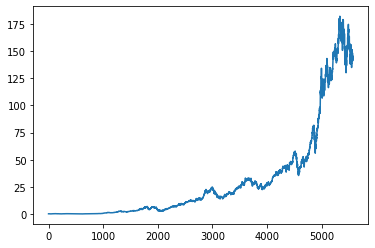

In [ ]:
plt.plot(df_close)

DATA preparation

In [ ]:

from sklearn.preprocessing import MinMaxScaler
# data normalization normal scaler 

scaler=MinMaxScaler(feature_range=(0,1))
a=np.array(df_close).reshape(-1,1)#df_close shape is (4942,) so change to (4942,1) as fit takes minimum of(1,1)
print(a.shape)


(5573, 1)


In [ ]:
df_trans=scaler.fit_transform(a)
print(df_trans,"\n\n\n",df_close)

[[6.26750439e-04]
 [7.12708019e-04]
 [5.65356173e-04]
 ...
 [7.93591843e-01]
 [7.98983079e-01]
 [7.86550205e-01]] 


 0         0.348214
1         0.363839
2         0.337054
3         0.330357
4         0.330357
           ...    
5568    142.649994
5569    142.160004
5570    144.490005
5571    145.470001
5572    143.210007
Name: Close, Length: 5573, dtype: float64


Train test split

cannot use
random seed
cross validation 
as stock market data has to be in series or else it will lose its integrity

In [ ]:
sizeee= int(len(df_trans)*0.7)
train,test= df_trans[0:sizeee,:],df_trans[sizeee:len(df_trans),:1]# 70 30 split
print("train= ",len(train),"\ttest=",len(test))
df_trans[0:3457,:]

train=  3901 	test= 1672


array([[0.00062675],
       [0.00071271],
       [0.00056536],
       ...,
       [0.12858271],
       [0.12790881],
       [0.12898156]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,ytest.shape)

(3800, 100) (3800,)
(1571, 100) (1571,)


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,ytest.shape)

(3800, 100, 1) (3800,)
(1571, 100, 1) (1571,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(100,1)))#100 as it is given for 100 
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 100)          40800     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           30200     
                                                                 
 lstm_8 (LSTM)               (None, 10)                2440      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=45,batch_size=32,verbose=1)

Epoch 1/45
119/119 [==============================] - 7s 30ms/step - loss: 2.0479e-04 - val_loss: 0.0066
Epoch 2/45
119/119 [==============================] - 3s 29ms/step - loss: 1.1999e-05 - val_loss: 0.0061
Epoch 3/45
119/119 [==============================] - 4s 31ms/step - loss: 1.4113e-05 - val_loss: 0.0071
Epoch 4/45
119/119 [==============================] - 4s 30ms/step - loss: 1.1053e-05 - val_loss: 0.0080
Epoch 5/45
119/119 [==============================] - 3s 23ms/step - loss: 1.1196e-05 - val_loss: 0.0069
Epoch 6/45
119/119 [==============================] - 2s 17ms/step - loss: 1.1569e-05 - val_loss: 0.0065
Epoch 7/45
119/119 [==============================] - 2s 17ms/step - loss: 1.2302e-05 - val_loss: 0.0066
Epoch 8/45
119/119 [==============================] - 2s 17ms/step - loss: 1.0234e-05 - val_loss: 0.0049
Epoch 9/45
119/119 [==============================] - 2s 17ms/step - loss: 9.5134e-06 - val_loss: 0.0045
Epoch 10/45
119/119 [==============================] - 

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

from sklearn.metrics import mean_squared_error
import math 
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
math.sqrt(mean_squared_error(ytest,test_predict))

50/50 [==============================] - 0s 7ms/step


0.044744490250642394

In [ ]:
mean_squared_error(ytest,test_predict, squared=False)
#60=0.01983439163990259
#30=0.011527204271548101
#100=0.009140388300708647
#40=0.010243986870943567
#45=0.009436282688502006

0.044744490250642394

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


model1=Sequential()
model1.add(LSTM(100,return_sequences=True,input_shape=(100,1)))#100 as it is given for 100 
model1.add(LSTM(100,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(25))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')
history=model1.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=45,batch_size=32,verbose=1)



Epoch 1/45
119/119 [==============================] - 12s 55ms/step - loss: 1.4097e-04 - val_loss: 0.0026
Epoch 2/45
119/119 [==============================] - 3s 26ms/step - loss: 1.5029e-05 - val_loss: 0.0044
Epoch 3/45
119/119 [==============================] - 2s 18ms/step - loss: 1.5021e-05 - val_loss: 0.0047
Epoch 4/45
119/119 [==============================] - 2s 18ms/step - loss: 1.1302e-05 - val_loss: 0.0032
Epoch 5/45
119/119 [==============================] - 2s 18ms/step - loss: 1.2331e-05 - val_loss: 0.0019
Epoch 6/45
119/119 [==============================] - 2s 18ms/step - loss: 9.9494e-06 - val_loss: 0.0015
Epoch 7/45
119/119 [==============================] - 2s 19ms/step - loss: 1.2618e-05 - val_loss: 0.0034
Epoch 8/45
119/119 [==============================] - 2s 18ms/step - loss: 1.2289e-05 - val_loss: 0.0023
Epoch 9/45
119/119 [==============================] - 2s 18ms/step - loss: 9.4279e-06 - val_loss: 0.0018
Epoch 10/45
119/119 [==============================] -

In [ ]:
train_predict1=model1.predict(X_train)
test_predict1=model1.predict(X_test)

from sklearn.metrics import mean_squared_error
import math 

math.sqrt(mean_squared_error(ytest,test_predict1))

50/50 [==============================] - 0s 7ms/step


0.014767594467389967

In [ ]:
test_predict.shape

(1571, 1)

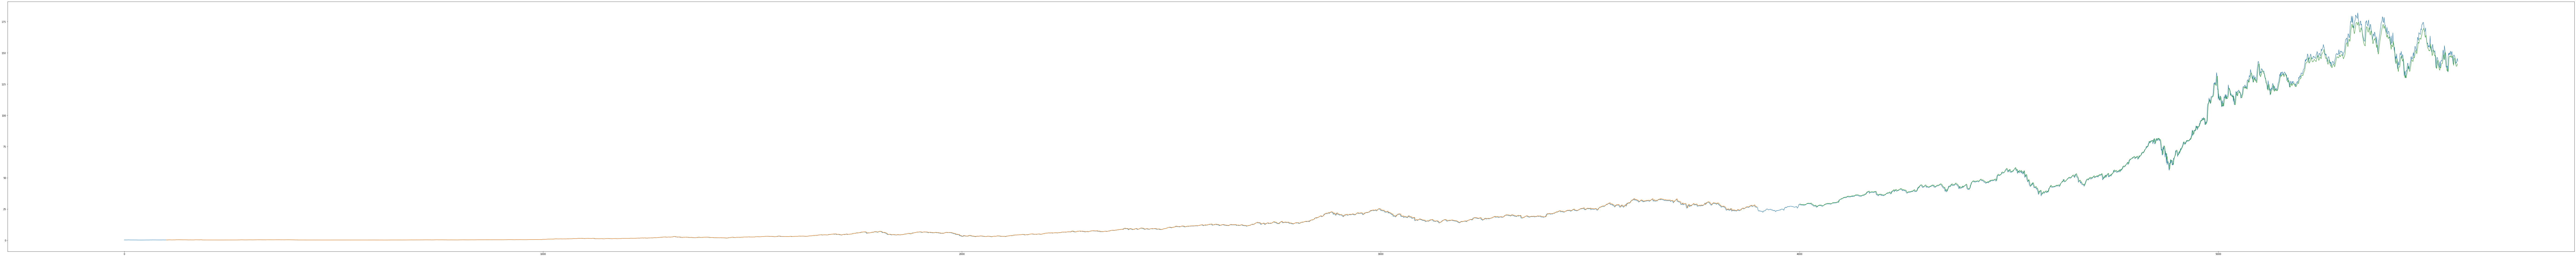

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df_trans)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict1)+look_back, :] = train_predict1
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df_trans)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict1)+(look_back*2)+1:len(df_trans)-1, :] = test_predict1
# plot baseline and predictions
plt.figure(figsize=(200,20))
plt.plot(scaler.inverse_transform(df_trans))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()
